# MLP
MLP, K=5, epochs=200.
Use lncRNA.
Train set: filter none.
Valid set: filter none.

Canonical transcripts. GMM threshold.

In [1]:
from datetime import datetime
print(datetime.now())

2023-04-04 15:18:42.917414


In [2]:
import tensorflow as tf
dt='float32'
tf.keras.backend.set_floatx('float32')
# tf.random.set_seed(42) # supposedly leads to reproducible results

device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
    print('GPU device not found')
else:
    print('Found GPU at: {}'.format(device_name))

try:
    from google.colab import drive
    IN_COLAB = True
    print('Running on CoLab')
    PATH='/content/drive/'
    drive.mount(PATH)
    DATA_DIR=PATH+'My Drive/data/Localization/TrainTest/TrainTest_ver43/'  # must end in "/"
except:
    IN_COLAB = False
    DATA_DIR = 'D:/Adjeroh/Localization/TrainTest/'   # Windows
    DATA_DIR = '/Users/jasonmiller/WVU/Localization/TrainTest/TrainTest_ver43/'    # Mac
print(DATA_DIR)

GPU device not found
Running on CoLab
Mounted at /content/drive/
/content/drive/My Drive/data/Localization/TrainTest/TrainTest_ver43/


In [3]:
from platform import python_version
print('Python',python_version())
import numpy as np
import pandas as pd
import scipy.stats as ss
import pickle
import time # sleep function
from os.path import isfile
from matplotlib import pyplot as plt 
import sklearn   # pip install --upgrade scikit-learn
print('sklearn',sklearn.__version__)

from tensorflow import keras
from sklearn.mixture import GaussianMixture
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import auc
from sklearn.metrics import matthews_corrcoef
from sklearn.utils import class_weight
from sklearn.metrics import confusion_matrix

from keras.models import Sequential
from keras.layers import Masking
from keras.layers import Embedding
from keras.layers import Conv1D
from keras.layers import GlobalAveragePooling1D
from keras.layers import GlobalMaxPooling1D
from keras.layers import AveragePooling1D
from keras.layers import MaxPooling1D
from keras.layers import Bidirectional
from keras.layers import LSTM
from keras.layers import TimeDistributed
from keras.layers import Flatten
from keras.layers import Dense
from keras.layers import Dropout
from keras.losses import BinaryCrossentropy

K=5
ALPHABET=4**K + 1
CFILTERS=64 
FILTERSIZE=8
RCELLS=32
DCELLS=16
EPOCHS=200 
EMBED_DIMEN = 4 # arbitrary hyperparameter
# MINLEN=200   # NO LONGER USED
MAXLEN=5000   
PRETTY_PICTURES = True
RCI_THRESHOLD_MECHANISM = 'RCI_GMM'  # 'RCI_GMM' 'ZERO' 'THE_MEAN'
BREAK = False   # break after first fold
EXCLUSIONS = [1]   # possibly exclude cell line 1 = H1.hESC
FILTER_TRAIN        = False
FILTER_TAILS_TRAIN  = False
FILTER_MIDDLE_TRAIN = False
FILTER_TEST         = False
FILTER_TAILS_TEST   = False
FILTER_MIDDLE_TEST  = False

Python 3.9.16
sklearn 1.2.2


In [4]:
RCI_FILE_TRAIN = 'train.lncRNA_RCI.csv'
RCI_FILE_VALID = 'train.lncRNA_RCI.csv'
RCI_FILE_TEST  = None # else 'test.lncRNA_RCI.csv'

SEQ_FILE_TRAIN = 'train.canon_lncRNA_transcripts.csv'
SEQ_FILE_VALID = 'train.canon_lncRNA_transcripts.csv'
SEQ_FILE_TEST  = None # else 'test.canon_lncRNA_transcripts.csv'

In [5]:
def get_ordered_list():
    ordered_list = \
    ['A549','H1.hESC','HeLa.S3','HepG2','HT1080',\
      'HUVEC','MCF.7','NCI.H460','NHEK','SK.MEL.5',\
      'SK.N.DZ','SK.N.SH','GM12878','K562','IMR.90']
    return ordered_list
all_cell_lines = get_ordered_list()

## Data Load

In [6]:
class DataLoader():
    def __init__(self):
        self.cache=dict() 
        self.vals = {'A':0, 'C':1, 'G':2, 'T':3}
        self.gene2rci = dict()
        
    def load_gene_rci_values(self,filepath,exclusions):
        '''
        Load all the genes from the given RCI csv file.
        The given file usually contains train or test, not both.
        Load average RCI for each across cell lines.
        Define average as log of mean of antilogs: log2(mean(2^RCI)).
        Return dict with keys=gene:str and values=RCI:float.
        '''
        self.gene2rci = {}
        overall_sum = 0
        with open (filepath,'r') as handle:
            header = None
            for row in handle:
                if header is None:
                    header = row # skip file's header line
                else:
                    line = row.strip()
                    fields = line.split(',')
                    gene_id = fields.pop(0)
                    cell_line_index = 0
                    rci_values = []
                    log_mean=0.0
                    for rci_str in fields:
                        if cell_line_index not in exclusions:
                            if rci_str != "nan":
                                rci_val = float(rci_str)
                                rci_values.append(rci_val)
                        cell_line_index += 1
                    if len(rci_values)>0:
                        values = np.array(rci_values)
                        antilogs = [2**x for x in values]
                        big_mean = np.mean(antilogs)
                        if np.absolute(big_mean)<0.000001:
                            log_mean = -1000000 # neg infinity
                        else:
                            log_mean = np.log2(big_mean) 
                        self.gene2rci[gene_id] = log_mean
                    # TO DO: get rid of this check on our log/antilog arithmetic.
                    if len(rci_values)==1:
                        diff = rci_values[0]-log_mean
                        if diff>0.000001:
                            print('antilog',log_mean,'not equal',rci_values,'for gene',gene_id)
        print('Number of RCI values loaded',len(self.gene2rci.keys()))
        return self.gene2rci

    def _seq_to_kmer_values(self,rna,K):
        vec=[] # seq converted to list of K-mers 
        N_indicator = 0 # indicator value
        length = len(rna)
        for i in range(length-K+1):
            kmer = rna[i:i+K]
            if 'N' in kmer:
                value = N_indicator
            elif kmer in self.cache.keys():
                value = self.cache[kmer]
            else:
                value = 0
                for j in range(K):
                    value *= 4   
                    nextnuc = kmer[j] 
                    nucval = self.vals[nextnuc]
                    value += nucval
                value += 1   # NNN => 0, AAA => 1
                self.cache[kmer] = value
            vec.append(value)
        return vec

    def load_sequence(self,filepath):
        '''
        Load all the sequences from the given file. 
        Load our version of GenCode -- csv, easier to parse than fasta.
        Each line has IDs plus sequence.
        The IDs in the file do not include dot-version numbers.
        The file may already be filtered e.g. canonical transcripts.
        '''
        allids=[]
        allseq=[]
        NREPEAT = str('N'*MAXLEN)
        with open (filepath,'r') as handle:
            header = None
            for row in handle:
                if header is None:
                    header = row
                else:
                    line    = row.strip()
                    fields  = line.split(',')
                    tran_id = fields[0]  # without version number
                    gene_id = fields[1]  # without version number
                    seq_len = int(fields[3])
                    seq_txt = fields[4]
                    # Keep only transcripts having numeric RCI given the cell lines in use.
                    # We have validated this by spot checking.
                    # TO DO: validate this programmatically.
                    if gene_id in self.gene2rci.keys():
                        if seq_len<=MAXLEN:
                            seq_txt = seq_txt + NREPEAT
                        seq_txt = seq_txt[:MAXLEN]
                        allids.append( (gene_id,tran_id) )
                        hot_vec = self._seq_to_kmer_values(seq_txt,K)
                        allseq.append(hot_vec)
        self.cache=dict() # save RAM
        return allids,allseq

    def load_spectra(self,filepath):
        '''
        Load all (variable-length) sequences as lists of kmers.
        Then convert each sequence to (fixed-length) kmer histograms.
        '''
        allids,allseq = self.load_sequence(filepath)
        allspectra = []
        for seq in allseq:
            spectrum = np.zeros(ALPHABET)
            for kmer in seq:
                spectrum[kmer] += 1
            spectrum /= len(seq)
            allspectra.append(spectrum)
        return allids,allspectra        


## Model

In [7]:
def build_model():
    mlp    = Sequential()
    layer1 = Dense(64, activation='sigmoid',dtype=dt,input_dim=ALPHABET)
    layer2 = Dense(64, activation='sigmoid')
    layer3 = Dense(64, activation='sigmoid')
    output = Dense(1, activation='sigmoid')
    mlp.add(layer1)
    mlp.add(layer2)
    mlp.add(layer3)
    mlp.add(output)
      
    bc=BinaryCrossentropy(from_logits=False)
    mlp.compile(loss=bc, optimizer="Adam",metrics=["accuracy"])
    return mlp

In [8]:
print(datetime.now())
model=build_model()
print(model.summary())  # Print this only once
model=None

2023-04-04 15:19:15.025295
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 64)                65664     
                                                                 
 dense_1 (Dense)             (None, 64)                4160      
                                                                 
 dense_2 (Dense)             (None, 64)                4160      
                                                                 
 dense_3 (Dense)             (None, 1)                 65        
                                                                 
Total params: 74,049
Trainable params: 74,049
Non-trainable params: 0
_________________________________________________________________
None


## Training

In [9]:
import gc
class CrossValidator():
    def __init__(self,epochs,quick_test=False,score_threshold=0.5):
        self.epochs = epochs
        self.quick_test = quick_test
        self.score_threshold = score_threshold
        self.mechanism = 'ZERO'
        self.discriminator = None
        self.flip = False
        self.reset_statistics()
        
    def reset_statistics(self):
        self.cv_accuracy=[]
        self.cv_precision=[]
        self.cv_recall=[]
        self.cv_f1=[]
        self.cv_auprc=[]
        self.cv_auroc=[]
        self.cv_mcc=[]
        
    def _get_X_y(self, all_ids, all_seqs, rci_map, exclude_middle=False): 
        # Prepare X and y for training or testing.
        subsetX=[]
        subsetY=[]
        for t in range(len(all_ids)):
            gene_id,tran_id = all_ids[t]
            oneX            = all_seqs[t]
            oneY            = rci_map[gene_id]
            if exclude_middle and oneY >= -2 and oneY <= 0:
                # Exclude middle from train set only, for comparison to Yuan et al
                continue
            subsetX.append(oneX)
            subsetY.append(oneY)
        subsetX = np.array(subsetX)
        subsetY = np.array(subsetY).reshape((-1,1))
        return subsetX,subsetY
    
    def set_threshold_mechanism(self, mechanism):
        if mechanism not in ['RCI_GMM','THE_MEAN','ZERO']:
            raise Exception('Unrecognized mechansm:',mechanism)
        self.mechanism = mechanism
    
    def _apply_threshold(self, array_of_rci):
        # Takes list of float, returns list of labels [0,1].
        if self.mechanism == 'RCI_GMM':
            labels = self.discriminator.predict(array_of_rci)
            if self.flip:
                IS_CYTO = lambda label: 1 if label==0 else 0
                labels = np.array(list(map(IS_CYTO, labels)))
        else:  # 'THE_MEAN' or 'ZERO'
            rci_threshold = self.discriminator
            IS_CYTO = lambda rci: 1 if rci>rci_threshold else 0
            labels = np.array(list(map(IS_CYTO, array_of_rci)))
        return labels
    
    def _prepare_threshold(self, rci_values, create=True):
        if self.mechanism == 'RCI_GMM':
            if create:  # during training, create a new GMM
                gmm = GaussianMixture(n_components=2, verbose=0, 
                  covariance_type='spherical', n_init=100) # random_state=42) 
                gmm.fit(rci_values)
            else:   # during testing, use existing GMM
                gmm=self.discriminator
            self.flip = False
            # The GMM labels are arbitrary.
            if gmm.means_[0][0] > gmm.means_[1][0]:
                self.flip = True
            self.discriminator = gmm   # redundant but consistent
        elif self.mechanism == 'THE_MEAN':
            self.discriminator = np.mean(rci_values)
        elif self.mechanism == 'ZERO':
            self.discriminator = -1   # 0 usually, -1 is as in Yuan et al.
        else: # not expected
            self.discriminator = 0
    
    def _explain_threshold(self):
        if self.mechanism == 'RCI_GMM':
            gmm=self.discriminator
            print('Discriminator is GMM')
            print('Means',[gmm.means_[0][0],gmm.means_[1][0]])
            print('Variances',gmm.covariances_)
            print('Priors',gmm.weights_)
            test_rcis=[-5,-4,-3.5,-3,-2.5,-2,-1.5,-1,-0.5,0,0.5,1,1.5,2,3]
            print(test_rcis)
            print(self._apply_threshold(np.array(test_rcis).reshape((-1,1))))
        else:
            print('Discriminator',self.mechanism,self.discriminator)
    
    def _show_sizes(self,label,values):
        a = np.count_nonzero(values==1)
        b = np.count_nonzero(values==0)
        print('%s 1:0 %d:%d %5.2f%%'%(label,a,b,100*a/(a+b)))
        
    def save_model(self,filename):
        if self.model is not None:
            self.model.save(filename)
        
    def load_model(self,filename):
        self.model = keras.models.load_model(filename)
        
    def train_new_model(self,train_ids,train_seq,train_rci,
            valid_ids=None,valid_seq=None,valid_rci=None):
        print(datetime.now())
        X_train,y_rci = self._get_X_y(train_ids,train_seq,train_rci) 
        self._prepare_threshold(y_rci,True)  
        self._explain_threshold()
        y_train = self._apply_threshold(y_rci)
        self._show_sizes('Train',y_train)
        cw = class_weight.compute_class_weight(
            'balanced', classes=[0,1], y=y_train)
        cwd = {0: cw[0], 1: cw[1]}
        print('Computed class weights:',cwd)
        if valid_ids is not None:
            X_valid,y_rci = self._get_X_y(valid_ids,valid_seq,valid_rci) 
            y_valid = self._apply_threshold(y_rci)
            self._show_sizes('Valid',y_valid)
        y_rci = None

        self.model=build_model()
        print("FIT")
        print(datetime.now())
        if valid_ids is None:
            history=self.model.fit(X_train, y_train, # batch_size=10, default=32 works nicely
            epochs=self.epochs, verbose=0,  # verbose=1 for ascii art, verbose=0 for none 
            class_weight=cwd) # no validation
        else:
            history=self.model.fit(X_train, y_train, # batch_size=10, default=32 works nicely
            epochs=self.epochs, verbose=0,  # verbose=1 for ascii art, verbose=0 for none 
            class_weight=cwd, 
            validation_data=(X_valid,y_valid) ) 

        if PRETTY_PICTURES:
            pd.DataFrame(history.history).plot(figsize=(8,5))
            plt.grid(True)
            plt.gca().set_ylim(0,1)
            plt.show()
        
    def test_without_training(self,test_ids,test_seq,test_rci):
        # For final test, do no train.
        # Assume set_sequences() set the test set.
        print(datetime.now())
        X_test,y_rci = self._get_X_y(test_ids,test_seq,test_rci) 
        y_test = self._apply_threshold(y_rci)
        y_rci = None
        
        print("PREDICT")
        print(datetime.now())        
        yhat_pred=self.model.predict(X_test, verbose=0)     
        yhat_classes=np.where(yhat_pred > self.score_threshold, 1, 0)

        self._show_sizes('Test',y_test)
        self._show_sizes('Predict',yhat_classes)
        print('Test sizes',X_test.shape,y_test.shape)
        print('Range of scores:',np.min(yhat_pred),'to',np.max(yhat_pred))
        print('Score threshold',self.score_threshold)
        cm1 = confusion_matrix(y_test,yhat_classes)
        print('Confusion matrix\n',cm1)
        cm2 = confusion_matrix(y_test,yhat_classes,normalize='all')
        print('Normalized matrix\n',cm2)

        accuracy = accuracy_score(y_test, yhat_classes)*100.
        precision = precision_score(y_test, yhat_classes)*100.
        recall = recall_score(y_test, yhat_classes)*100.
        f1 = f1_score(y_test, yhat_classes)*100.
        prc_Y, prc_X, prc_bins = precision_recall_curve(y_test, yhat_pred)
        auprc = auc(prc_X,prc_Y)*100.
        auroc = roc_auc_score(y_test, yhat_pred)*100.
        mcc = matthews_corrcoef(y_test, yhat_classes)
        if PRETTY_PICTURES:
            self._pretty_pictures(y_test,yhat_pred,prc_X,prc_Y)
            print('Accuracy: %.2f%% Precision: %.2f%% Recall: %.2f%%' % (accuracy,precision,recall)) 
            print('F1: %.2f%% MCC: %.4f' % (f1,mcc)) 
            print('AUPRC: %.2f%% AUROC: %.2f%%' % (auprc,auroc)) 
        self.cv_accuracy.append(accuracy)
        self.cv_precision.append(precision)
        self.cv_recall.append(recall)
        self.cv_f1.append(f1)
        self.cv_mcc.append(mcc)
        self.cv_auprc.append(auprc)
        self.cv_auroc.append(auroc)

    def _pretty_pictures(self,y_valid,yhat_pred,prc_X,prc_Y):
        count_ones= len(y_valid[y_valid==1])
        count_zeros= len(y_valid[y_valid==0])
        guess = max(count_ones,count_zeros) / len(y_valid)
        # PRC
        plt.plot(prc_X, prc_Y, marker='.')
        plt.plot([0, 1], [guess,guess], linestyle='--')
        plt.xlabel('Recall')
        plt.ylabel('Precision')
        plt.show()
        # ROC
        fpr, tpr, roc_bins = roc_curve(y_valid, yhat_pred)
        plt.plot(fpr, tpr, marker='.')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.show()
        
    def get_statistics(self):
        return \
        self.cv_accuracy,\
        self.cv_precision,\
        self.cv_recall,\
        self.cv_f1,\
        self.cv_mcc,\
        self.cv_auprc,\
        self.cv_auroc


## Train

In [10]:
class Separator():
    def __init__(self):
        self.train_ids = []
        self.train_seq = []
        self.train_rci = dict()
        self.val_ids = []
        self.val_seq = []
        self.val_rci = dict()
    def load(self,data_dir,rep,fold):
        filename='cv.{}.{}.validation_genes.txt'.format(rep,fold)
        filename = data_dir + filename
        self.val_genes = set()
        with open(filename,'r') as fin:
            for line in fin:
                gene_id = line.strip()
                self.val_genes.add(gene_id)
    def process(self,allids,allseq,gene_to_rci):
        size = len(allids)
        for t in range(size):
            gene_id,tran_id = allids[t]
            oneX            = allseq[t]
            oneY            = gene_to_rci[gene_id]
            in_middle = gene_to_rci[gene_id] >= -2 and gene_to_rci[gene_id] <= 0
            in_tails = gene_to_rci[gene_id] < -2 or gene_to_rci[gene_id] > 0
            if gene_id in self.val_genes:
                if not FILTER_TEST or \
                    (FILTER_TAILS_TEST and in_middle) or \
                    (FILTER_MIDDLE_TEST and in_tails):
                    self.val_ids.append(allids[t])
                    self.val_seq.append(allseq[t])
                    self.val_rci[gene_id]=gene_to_rci[gene_id]
            else:
                if not FILTER_TRAIN or \
                    (FILTER_TAILS_TRAIN and in_middle) or \
                    (FILTER_MIDDLE_TRAIN and in_tails):
                    self.train_ids.append(allids[t])
                    self.train_seq.append(allseq[t])
                    self.train_rci[gene_id]=gene_to_rci[gene_id]
    def get_ids(self):
        return self.train_ids,self.val_ids
    def get_seq(self):
        return self.train_seq,self.val_seq
    def get_rci(self):
        return self.train_rci,self.val_rci

2023-04-04 15:19:15.657782
Load RCI from /content/drive/My Drive/data/Localization/TrainTest/TrainTest_ver43/train.lncRNA_RCI.csv
Number of RCI values loaded 4369
Num RCI: 4369
Load sequence from /content/drive/My Drive/data/Localization/TrainTest/TrainTest_ver43/train.canon_lncRNA_transcripts.csv
Loaded 4369 sequences.
2023-04-04 15:19:38.106436

Training # 1 1
2023-04-04 15:19:38.107933
2023-04-04 15:19:38.108192
Discriminator is GMM
Means [-0.021984070700750723, -2.5130109773878346]
Variances [1.50516956 2.15414798]
Priors [0.57936818 0.42063182]
[-5, -4, -3.5, -3, -2.5, -2, -1.5, -1, -0.5, 0, 0.5, 1, 1.5, 2, 3]
[0 0 0 0 0 0 1 1 1 1 1 1 1 1 1]
Train 1:0 2153:1346 61.53%
Computed class weights: {0: 1.299777117384844, 1: 0.8125870877844867}
Valid 1:0 538:332 61.84%
FIT
2023-04-04 15:19:39.345606


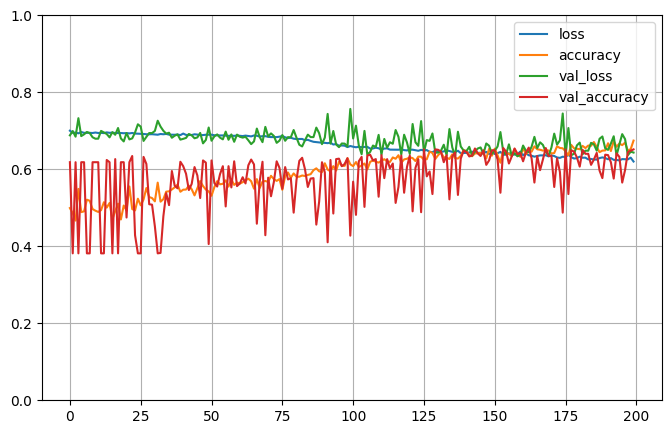


2023-04-04 15:20:56.587211

Testing # 1 1
2023-04-04 15:20:56.587298
2023-04-04 15:20:56.587332
PREDICT
2023-04-04 15:20:56.598043
Test 1:0 538:332 61.84%
Predict 1:0 591:279 67.93%
Test sizes (870, 1025) (870,)
Range of scores: 0.0121242525 to 0.9617473
Score threshold 0.5
Confusion matrix
 [[154 178]
 [125 413]]
Normalized matrix
 [[0.17701149 0.2045977 ]
 [0.14367816 0.47471264]]


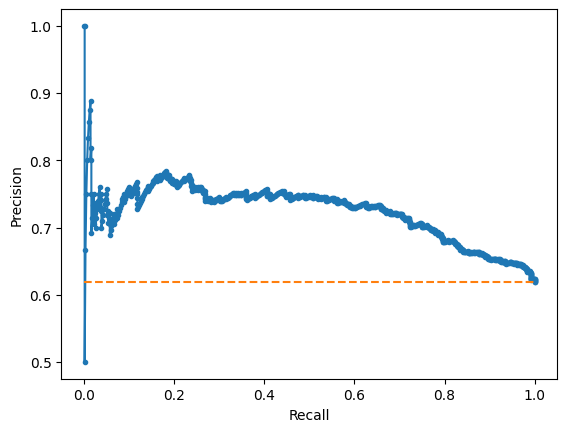

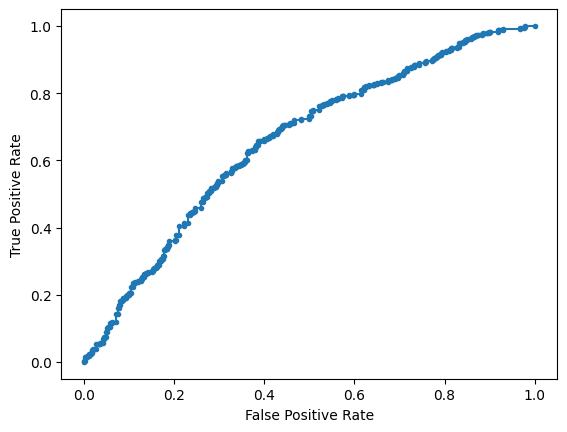

Accuracy: 65.17% Precision: 69.88% Recall: 76.77%
F1: 73.16% MCC: 0.2410
AUPRC: 72.38% AUROC: 65.64%
 accuracy [65.17241379310344]
 precision [69.88155668358715]
 recall [76.76579925650557]
 F1 [73.16209034543844]
 MCC [0.2409575270627673]
 AUPRC [72.38367494468329]
 AUROC [65.64137591257222]
2023-04-04 15:20:57.864727

Training # 1 2
2023-04-04 15:20:57.867053
2023-04-04 15:20:57.867519
Discriminator is GMM
Means [-2.5022412685008932, 0.00565458631949963]
Variances [2.28922828 1.48907794]
Priors [0.42519753 0.57480247]
[-5, -4, -3.5, -3, -2.5, -2, -1.5, -1, -0.5, 0, 0.5, 1, 1.5, 2, 3]
[0 0 0 0 0 0 0 1 1 1 1 1 1 1 1]
Train 1:0 2135:1350 61.26%
Computed class weights: {0: 1.2907407407407407, 1: 0.8161592505854801}
Valid 1:0 529:355 59.84%
FIT
2023-04-04 15:21:00.645941


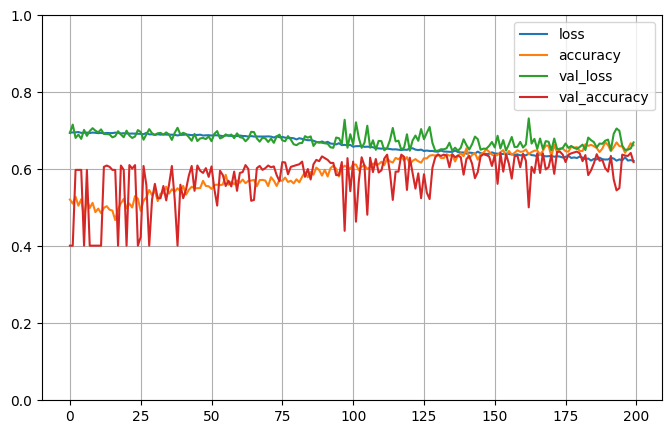


2023-04-04 15:22:23.808168

Testing # 1 2
2023-04-04 15:22:23.809990
2023-04-04 15:22:23.810408
PREDICT
2023-04-04 15:22:23.815500
Test 1:0 529:355 59.84%
Predict 1:0 454:430 51.36%
Test sizes (884, 1025) (884,)
Range of scores: 0.02097685 to 0.9795372
Score threshold 0.5
Confusion matrix
 [[224 131]
 [206 323]]
Normalized matrix
 [[0.25339367 0.14819005]
 [0.23303167 0.36538462]]


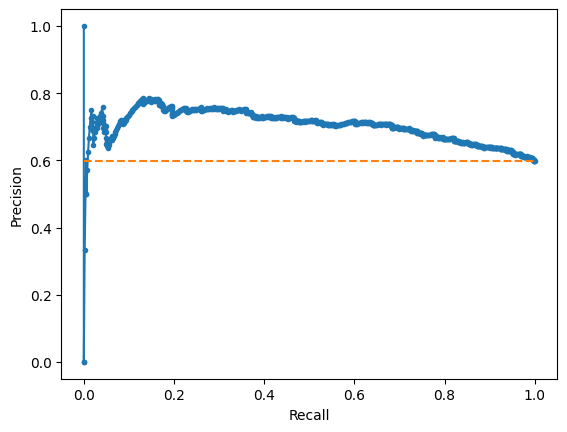

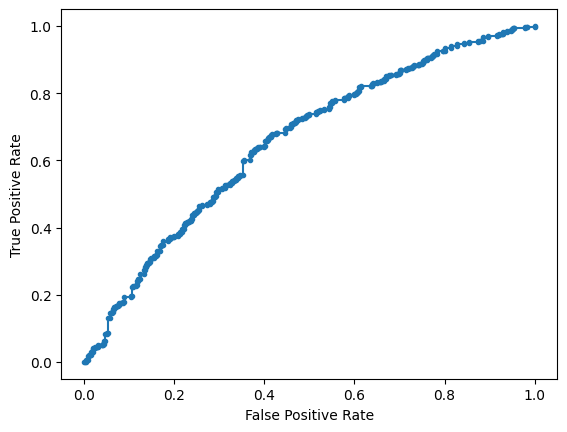

Accuracy: 61.88% Precision: 71.15% Recall: 61.06%
F1: 65.72% MCC: 0.2369
AUPRC: 70.31% AUROC: 65.41%
 accuracy [61.87782805429865]
 precision [71.1453744493392]
 recall [61.05860113421549]
 F1 [65.71719226856561]
 MCC [0.23693341913277052]
 AUPRC [70.3135355916354]
 AUROC [65.40695971671238]
2023-04-04 15:22:24.649155

Training # 1 3
2023-04-04 15:22:24.649469
2023-04-04 15:22:24.649528
Discriminator is GMM
Means [-0.0026252121421639608, -2.489918940535433]
Variances [1.50629361 2.26735568]
Priors [0.57405777 0.42594223]
[-5, -4, -3.5, -3, -2.5, -2, -1.5, -1, -0.5, 0, 0.5, 1, 1.5, 2, 3]
[0 0 0 0 0 0 0 1 1 1 1 1 1 1 1]
Train 1:0 2149:1371 61.05%
Computed class weights: {0: 1.2837345003646974, 1: 0.8189855746859004}
Valid 1:0 515:334 60.66%
FIT
2023-04-04 15:22:25.726791


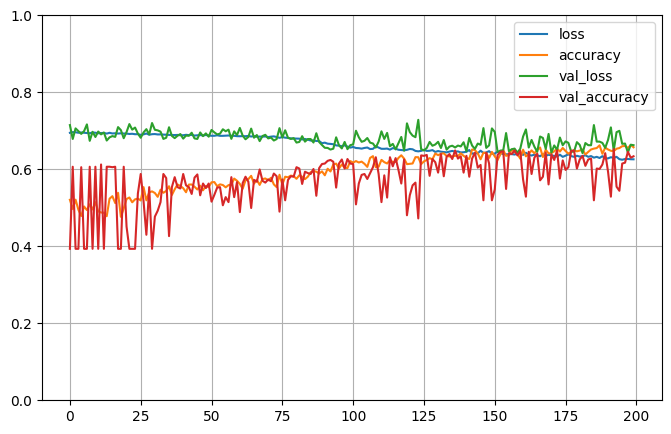


2023-04-04 15:23:49.030129

Testing # 1 3
2023-04-04 15:23:49.033479
2023-04-04 15:23:49.033955
PREDICT
2023-04-04 15:23:49.039772
Test 1:0 515:334 60.66%
Predict 1:0 438:411 51.59%
Test sizes (849, 1025) (849,)
Range of scores: 0.046446286 to 0.9697188
Score threshold 0.5
Confusion matrix
 [[217 117]
 [194 321]]
Normalized matrix
 [[0.25559482 0.13780919]
 [0.22850412 0.37809187]]


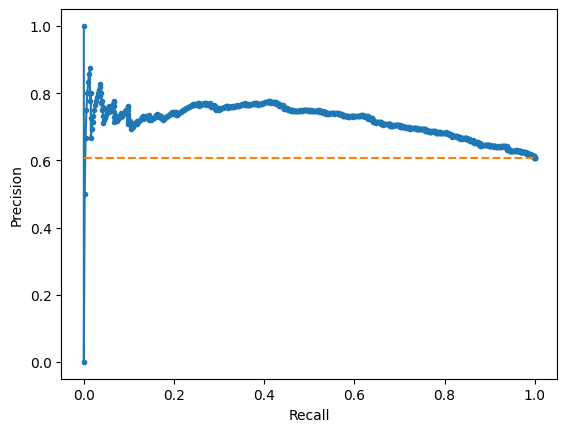

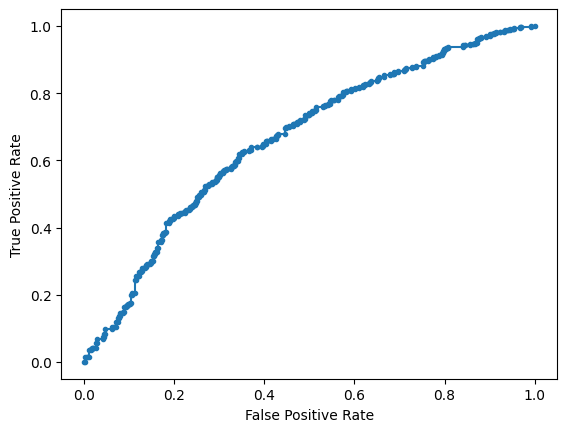

Accuracy: 63.37% Precision: 73.29% Recall: 62.33%
F1: 67.37% MCC: 0.2669
AUPRC: 71.88% AUROC: 66.31%
 accuracy [63.368669022379265]
 precision [73.28767123287672]
 recall [62.33009708737865]
 F1 [67.36621196222455]
 MCC [0.2668603343671529]
 AUPRC [71.87654561526983]
 AUROC [66.31358641939423]
2023-04-04 15:23:49.935986

Training # 1 4
2023-04-04 15:23:49.937489
2023-04-04 15:23:49.937546
Discriminator is GMM
Means [-2.527071518298245, 0.011440000735578097]
Variances [2.19513629 1.4816823 ]
Priors [0.42747628 0.57252372]
[-5, -4, -3.5, -3, -2.5, -2, -1.5, -1, -0.5, 0, 0.5, 1, 1.5, 2, 3]
[0 0 0 0 0 0 0 1 1 1 1 1 1 1 1]
Train 1:0 2116:1363 60.82%
Computed class weights: {0: 1.2762289068231842, 1: 0.822069943289225}
Valid 1:0 542:348 60.90%
FIT
2023-04-04 15:23:51.021487


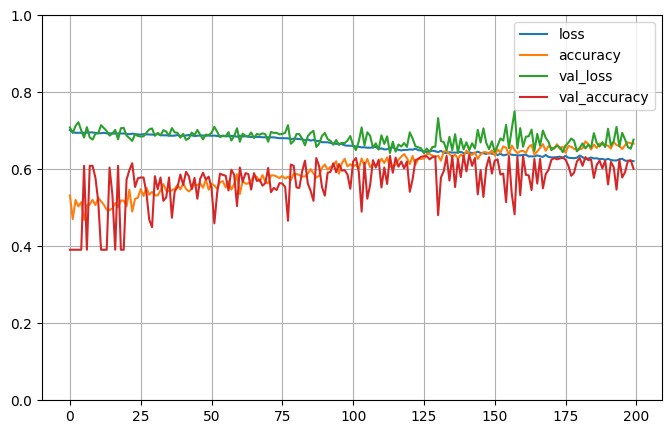


2023-04-04 15:25:06.063195

Testing # 1 4
2023-04-04 15:25:06.064900
2023-04-04 15:25:06.065294
PREDICT
2023-04-04 15:25:06.077530
Test 1:0 542:348 60.90%
Predict 1:0 447:443 50.22%
Test sizes (890, 1025) (890,)
Range of scores: 0.0142845595 to 0.93350935
Score threshold 0.5
Confusion matrix
 [[218 130]
 [225 317]]
Normalized matrix
 [[0.24494382 0.14606742]
 [0.25280899 0.35617978]]


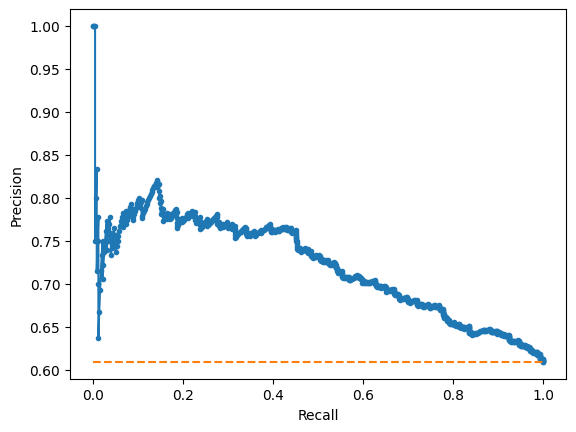

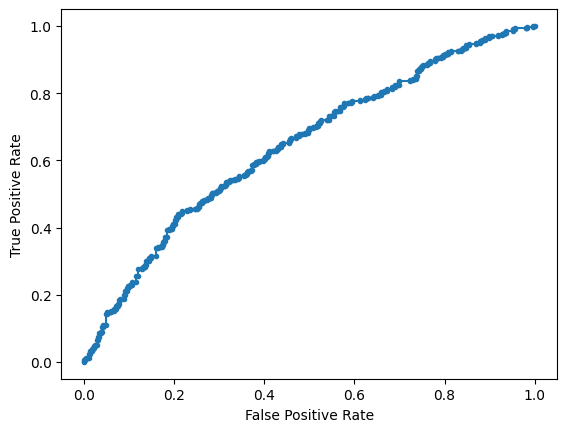

Accuracy: 60.11% Precision: 70.92% Recall: 58.49%
F1: 64.11% MCC: 0.2062
AUPRC: 72.03% AUROC: 64.33%
 accuracy [60.1123595505618]
 precision [70.917225950783]
 recall [58.487084870848705]
 F1 [64.1051567239636]
 MCC [0.20622856520755592]
 AUPRC [72.03305825215051]
 AUROC [64.32593205242398]
2023-04-04 15:25:07.366185

Training # 1 5
2023-04-04 15:25:07.368545
2023-04-04 15:25:07.368953
Discriminator is GMM
Means [-0.019981441668219767, -2.5421860071426576]
Variances [1.48814443 2.20632461]
Priors [0.57836639 0.42163361]
[-5, -4, -3.5, -3, -2.5, -2, -1.5, -1, -0.5, 0, 0.5, 1, 1.5, 2, 3]
[0 0 0 0 0 0 1 1 1 1 1 1 1 1 1]
Train 1:0 2145:1348 61.41%
Computed class weights: {0: 1.2956231454005935, 1: 0.8142191142191142}
Valid 1:0 552:324 63.01%
FIT
2023-04-04 15:25:09.120522


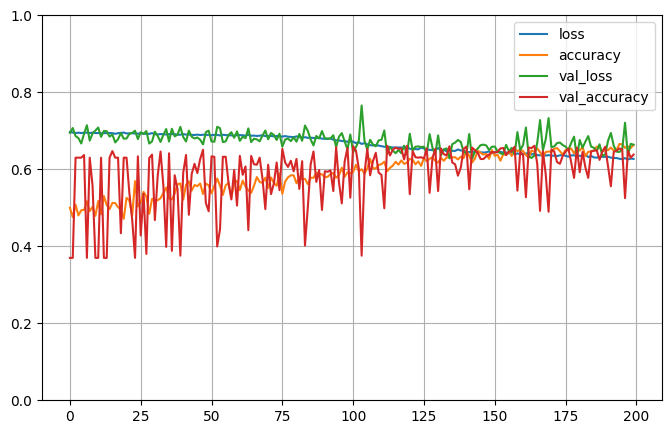


2023-04-04 15:26:23.800591

Testing # 1 5
2023-04-04 15:26:23.800717
2023-04-04 15:26:23.800759
PREDICT
2023-04-04 15:26:23.815798
Test 1:0 552:324 63.01%
Predict 1:0 475:401 54.22%
Test sizes (876, 1025) (876,)
Range of scores: 0.014557078 to 0.97330296
Score threshold 0.5
Confusion matrix
 [[204 120]
 [197 355]]
Normalized matrix
 [[0.23287671 0.1369863 ]
 [0.22488584 0.40525114]]


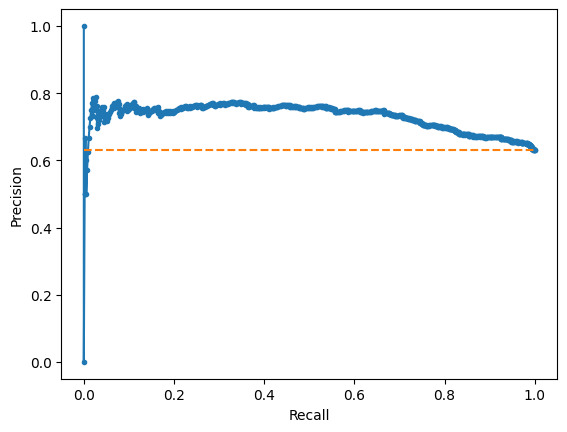

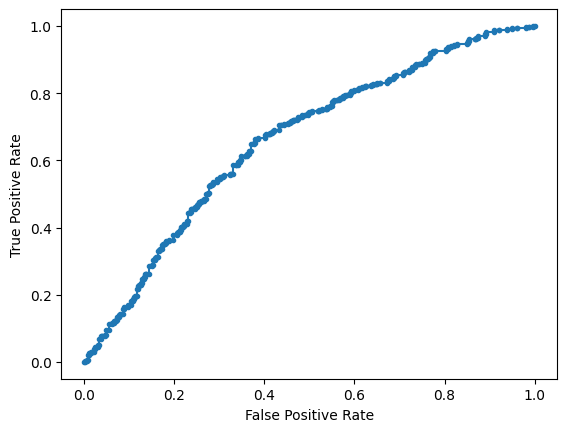

Accuracy: 63.81% Precision: 74.74% Recall: 64.31%
F1: 69.13% MCC: 0.2643
AUPRC: 73.01% AUROC: 65.85%
 accuracy [63.81278538812786]
 precision [74.73684210526315]
 recall [64.31159420289855]
 F1 [69.1333982473223]
 MCC [0.2642900182214585]
 AUPRC [73.01393274693552]
 AUROC [65.84585793522993]
2023-04-04 15:26:24.665314

Training # 2 1
2023-04-04 15:26:24.665554
2023-04-04 15:26:24.665612
Discriminator is GMM
Means [0.007029250118280219, -2.4853421264920206]
Variances [1.44726679 2.21761719]
Priors [0.56111635 0.43888365]
[-5, -4, -3.5, -3, -2.5, -2, -1.5, -1, -0.5, 0, 0.5, 1, 1.5, 2, 3]
[0 0 0 0 0 0 0 1 1 1 1 1 1 1 1]
Train 1:0 2068:1414 59.39%
Computed class weights: {0: 1.2312588401697313, 1: 0.8418762088974855}
Valid 1:0 553:334 62.34%
FIT
2023-04-04 15:26:25.701858


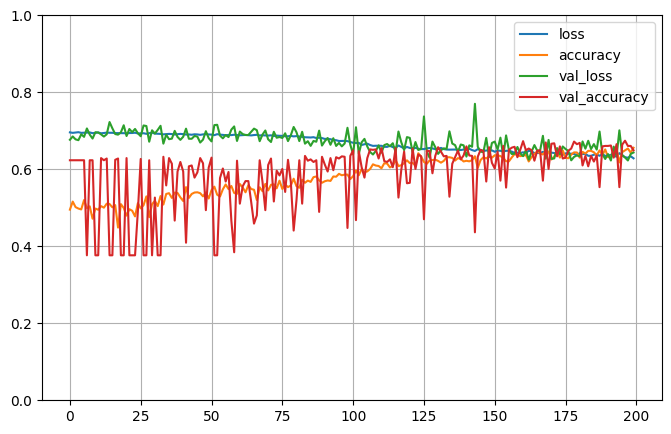


2023-04-04 15:27:48.846587

Testing # 2 1
2023-04-04 15:27:48.846720
2023-04-04 15:27:48.846767
PREDICT
2023-04-04 15:27:48.854929
Test 1:0 553:334 62.34%
Predict 1:0 526:361 59.30%
Test sizes (887, 1025) (887,)
Range of scores: 0.048659075 to 0.9886111
Score threshold 0.5
Confusion matrix
 [[192 142]
 [169 384]]
Normalized matrix
 [[0.21645998 0.16009019]
 [0.19052988 0.43291995]]


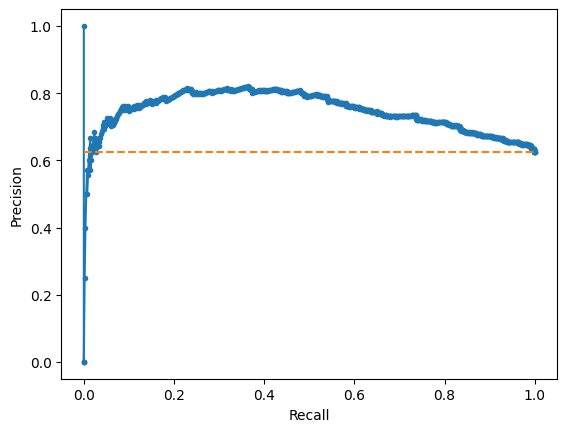

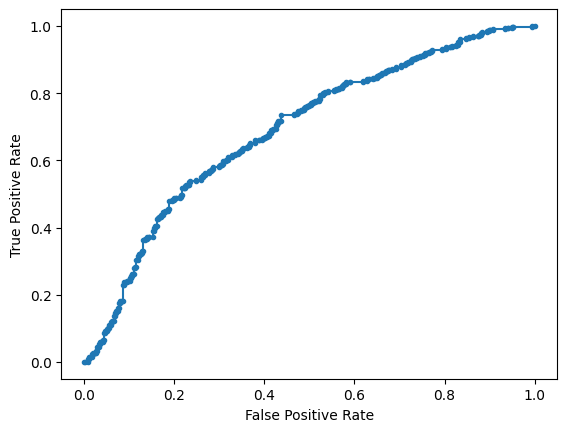

Accuracy: 64.94% Precision: 73.00% Recall: 69.44%
F1: 71.18% MCC: 0.2655
AUPRC: 74.49% AUROC: 68.92%
 accuracy [64.9379932356257]
 precision [73.00380228136882]
 recall [69.43942133815551]
 F1 [71.17701575532901]
 MCC [0.26554381303263647]
 AUPRC [74.48989684661606]
 AUROC [68.9245379042999]
2023-04-04 15:27:49.892716

Training # 2 2
2023-04-04 15:27:49.893622
2023-04-04 15:27:49.893712
Discriminator is GMM
Means [-0.01335649597785484, -2.505546739361269]
Variances [1.48694738 2.21985481]
Priors [0.57675941 0.42324059]
[-5, -4, -3.5, -3, -2.5, -2, -1.5, -1, -0.5, 0, 0.5, 1, 1.5, 2, 3]
[0 0 0 0 0 0 0 1 1 1 1 1 1 1 1]
Train 1:0 2153:1348 61.50%
Computed class weights: {0: 1.2985905044510386, 1: 0.8130515559684162}
Valid 1:0 528:340 60.83%
FIT
2023-04-04 15:27:51.307828


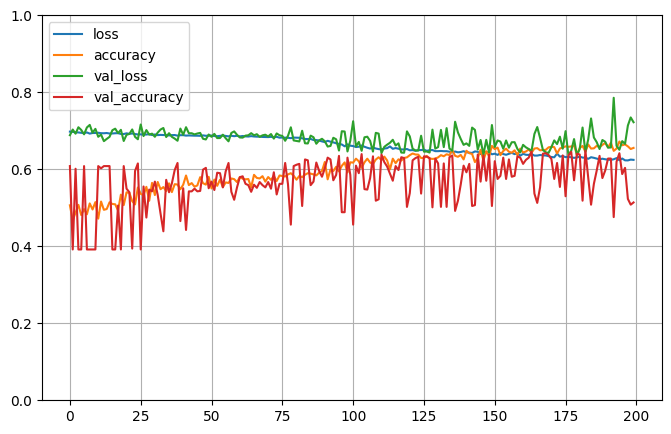


2023-04-04 15:29:15.489634

Testing # 2 2
2023-04-04 15:29:15.489759
2023-04-04 15:29:15.489812
PREDICT
2023-04-04 15:29:15.495396
Test 1:0 528:340 60.83%
Predict 1:0 212:656 24.42%
Test sizes (868, 1025) (868,)
Range of scores: 0.016801426 to 0.9466616
Score threshold 0.5
Confusion matrix
 [[287  53]
 [369 159]]
Normalized matrix
 [[0.33064516 0.06105991]
 [0.42511521 0.18317972]]


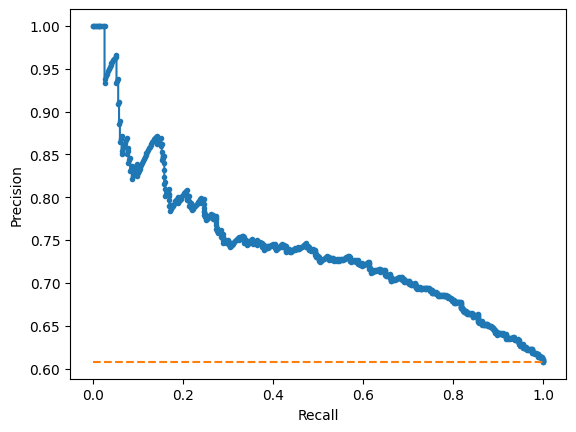

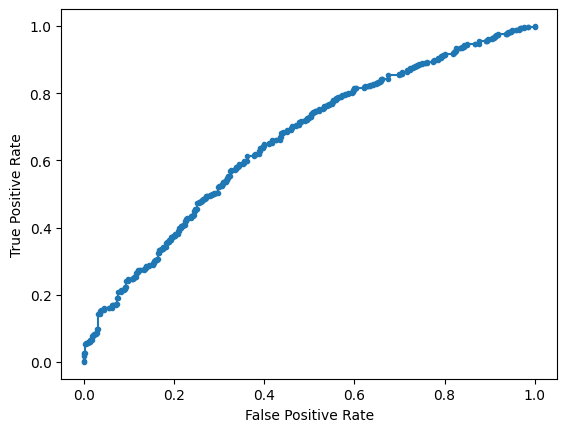

Accuracy: 51.38% Precision: 75.00% Recall: 30.11%
F1: 42.97% MCC: 0.1650
AUPRC: 74.35% AUROC: 65.86%
 accuracy [51.382488479262676]
 precision [75.0]
 recall [30.113636363636363]
 F1 [42.97297297297297]
 MCC [0.16503068504174487]
 AUPRC [74.34670861704812]
 AUROC [65.86285650623887]
2023-04-04 15:29:16.425134

Training # 2 3
2023-04-04 15:29:16.425352
2023-04-04 15:29:16.425420
Discriminator is GMM
Means [-2.5635275655845584, -0.03781001007016538]
Variances [2.21325292 1.54910884]
Priors [0.41325338 0.58674662]
[-5, -4, -3.5, -3, -2.5, -2, -1.5, -1, -0.5, 0, 0.5, 1, 1.5, 2, 3]
[0 0 0 0 0 0 1 1 1 1 1 1 1 1 1]
Train 1:0 2191:1318 62.44%
Computed class weights: {0: 1.3311836115326252, 1: 0.8007759014148791}
Valid 1:0 537:323 62.44%
FIT
2023-04-04 15:29:17.510885


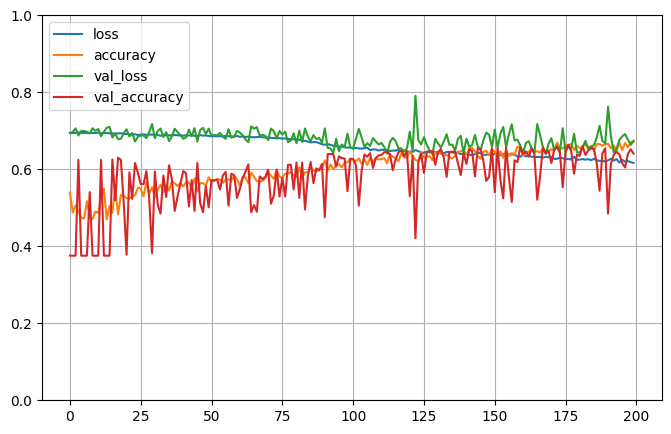


2023-04-04 15:30:35.613916

Testing # 2 3
2023-04-04 15:30:35.614053
2023-04-04 15:30:35.614098
PREDICT
2023-04-04 15:30:35.621509
Test 1:0 537:323 62.44%
Predict 1:0 460:400 53.49%
Test sizes (860, 1025) (860,)
Range of scores: 0.0071447575 to 0.9539782
Score threshold 0.5
Confusion matrix
 [[207 116]
 [193 344]]
Normalized matrix
 [[0.24069767 0.13488372]
 [0.2244186  0.4       ]]


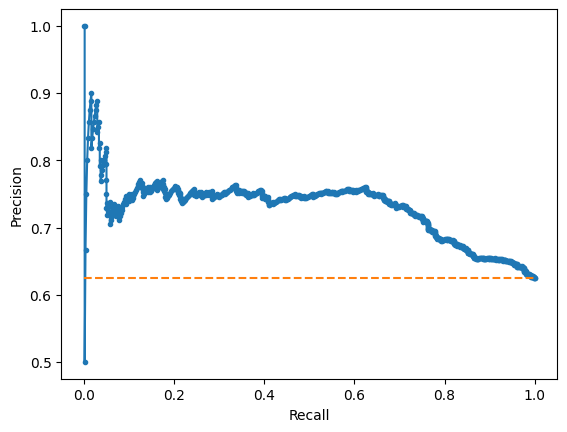

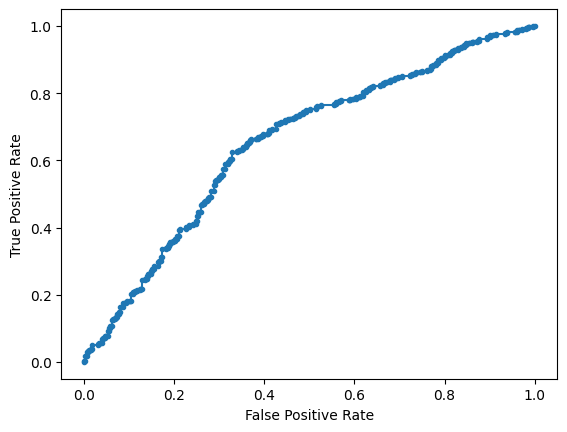

Accuracy: 64.07% Precision: 74.78% Recall: 64.06%
F1: 69.01% MCC: 0.2733
AUPRC: 72.96% AUROC: 65.35%
 accuracy [64.06976744186046]
 precision [74.78260869565217]
 recall [64.05959031657356]
 F1 [69.00702106318957]
 MCC [0.2732753502261488]
 AUPRC [72.95557868285928]
 AUROC [65.34813866740463]
2023-04-04 15:30:36.502668

Training # 2 4
2023-04-04 15:30:36.504799
2023-04-04 15:30:36.504900
Discriminator is GMM
Means [0.010236011268788184, -2.5450147661705227]
Variances [1.48776208 2.2463908 ]
Priors [0.58341681 0.41658319]
[-5, -4, -3.5, -3, -2.5, -2, -1.5, -1, -0.5, 0, 0.5, 1, 1.5, 2, 3]
[0 0 0 0 0 0 1 1 1 1 1 1 1 1 1]
Train 1:0 2167:1323 62.09%
Computed class weights: {0: 1.3189720332577475, 1: 0.8052607291185971}
Valid 1:0 528:351 60.07%
FIT
2023-04-04 15:30:37.653800


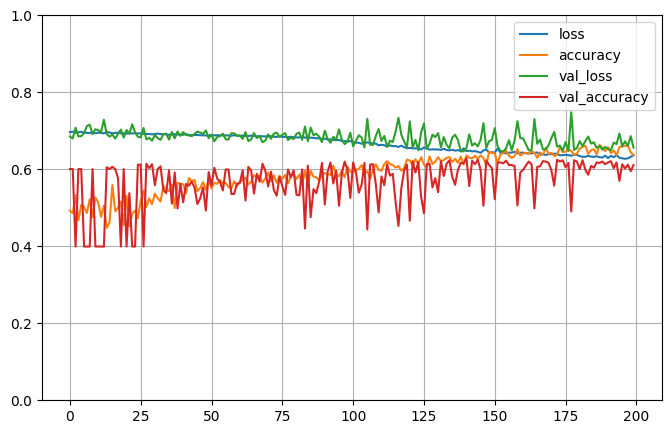


2023-04-04 15:32:01.485457

Testing # 2 4
2023-04-04 15:32:01.485581
2023-04-04 15:32:01.485621
PREDICT
2023-04-04 15:32:01.499806
Test 1:0 528:351 60.07%
Predict 1:0 610:269 69.40%
Test sizes (879, 1025) (879,)
Range of scores: 0.017237954 to 0.9403238
Score threshold 0.5
Confusion matrix
 [[139 212]
 [130 398]]
Normalized matrix
 [[0.15813424 0.24118316]
 [0.14789534 0.45278726]]


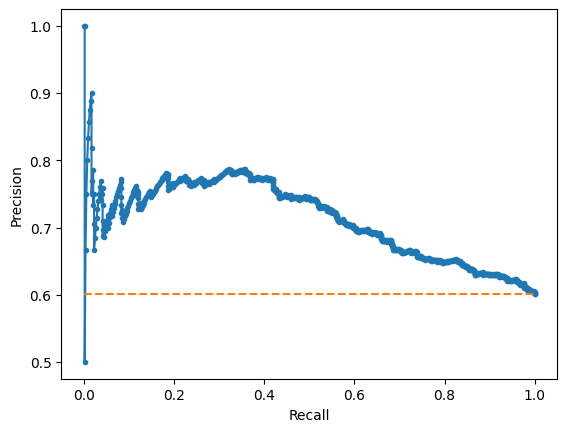

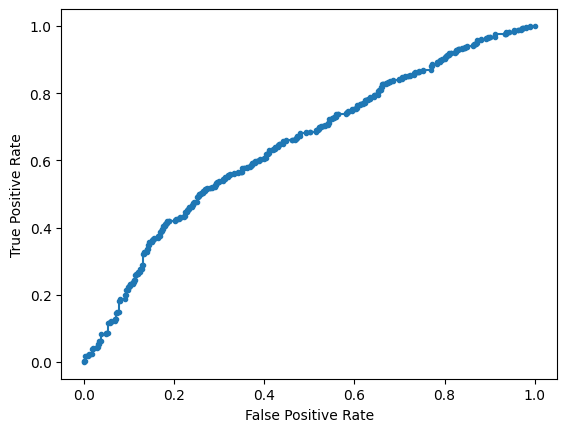

Accuracy: 61.09% Precision: 65.25% Recall: 75.38%
F1: 69.95% MCC: 0.1592
AUPRC: 71.25% AUROC: 64.59%
 accuracy [61.092150170648466]
 precision [65.24590163934427]
 recall [75.37878787878788]
 F1 [69.94727592267135]
 MCC [0.1591985738507985]
 AUPRC [71.24555038593707]
 AUROC [64.59250625917292]
2023-04-04 15:32:02.378204

Training # 2 5
2023-04-04 15:32:02.378832
2023-04-04 15:32:02.378892
Discriminator is GMM
Means [-2.511576408056661, -0.0135756102829319]
Variances [2.18615676 1.51755813]
Priors [0.41844038 0.58155962]
[-5, -4, -3.5, -3, -2.5, -2, -1.5, -1, -0.5, 0, 0.5, 1, 1.5, 2, 3]
[0 0 0 0 0 0 1 1 1 1 1 1 1 1 1]
Train 1:0 2165:1329 61.96%
Computed class weights: {0: 1.3145221971407073, 1: 0.8069284064665126}
Valid 1:0 529:346 60.46%
FIT
2023-04-04 15:32:03.500762


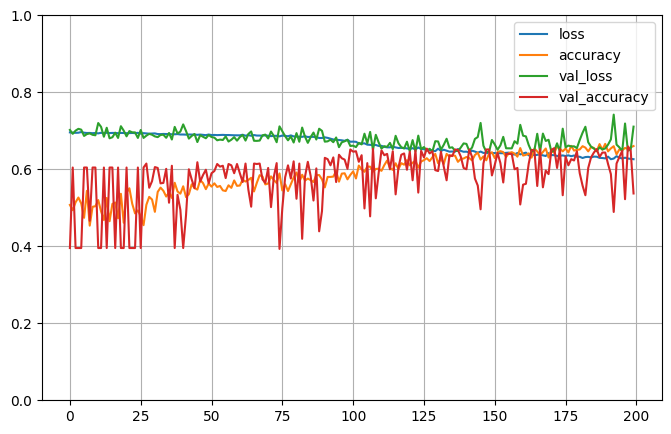


2023-04-04 15:33:26.668309

Testing # 2 5
2023-04-04 15:33:26.668429
2023-04-04 15:33:26.668484
PREDICT
2023-04-04 15:33:26.673192
Test 1:0 529:346 60.46%
Predict 1:0 274:601 31.31%
Test sizes (875, 1025) (875,)
Range of scores: 0.014794135 to 0.97271377
Score threshold 0.5
Confusion matrix
 [[271  75]
 [330 199]]
Normalized matrix
 [[0.30971429 0.08571429]
 [0.37714286 0.22742857]]


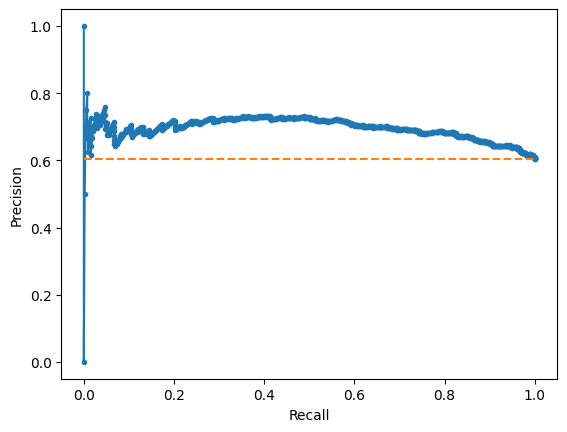

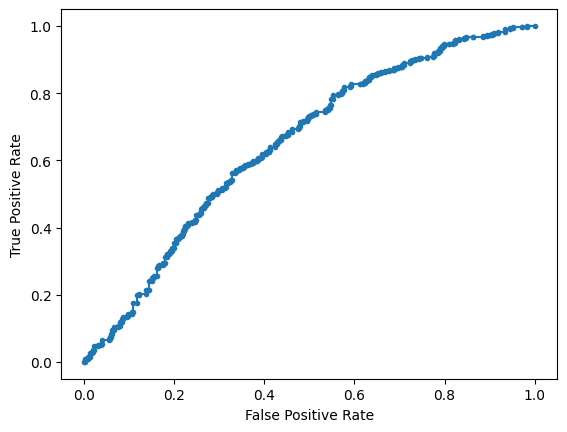

Accuracy: 53.71% Precision: 72.63% Recall: 37.62%
F1: 49.56% MCC: 0.1681
AUPRC: 69.45% AUROC: 64.79%
 accuracy [53.714285714285715]
 precision [72.62773722627736]
 recall [37.61814744801512]
 F1 [49.56413449564134]
 MCC [0.1680706970239676]
 AUPRC [69.44541982787801]
 AUROC [64.79451905110525]
2023-04-04 15:33:27.259816


In [11]:
print(datetime.now())

accuracy=[]
precision=[]
recall=[]
f1=[]
mcc=[]
auprc=[]
auroc=[]

loader = DataLoader()
filepath = DATA_DIR+RCI_FILE_TRAIN
print("Load RCI from",filepath)
gene_to_rci = loader.load_gene_rci_values(filepath,EXCLUSIONS)
print('Num RCI:', len(gene_to_rci.keys()))
filepath = DATA_DIR+SEQ_FILE_TRAIN
print('Load sequence from',filepath)
allids,allseq = loader.load_spectra(filepath)
print('Loaded',len(allseq),'sequences.')
test_gene_to_rci = None
test_allids = None
test_allseq = None
if SEQ_FILE_TEST is not None:
    # Train on the entire train set (no cross-validation).
    # Evaluate with the test files.
    test_loader = DataLoader()
    filepath = DATA_DIR+RCI_FILE_TEST
    print("Load RCI from",filepath)
    test_gene_to_rci = test_loader.load_gene_rci_values(filepath,EXCLUSIONS)
    print('Num RCI:', len(test_gene_to_rci.keys()))
    filepath = DATA_DIR+SEQ_FILE_TEST
    print('Load sequence from',filepath)
    test_allids,test_allseq = test_loader.load_spectra(filepath)
    print('Loaded',len(test_allseq),'sequences.')

REPEATS = 2
FOLDS = 5
for repeat in range(REPEATS):
    for fold in range(FOLDS):
        r = repeat+1
        f = fold+1

        if SEQ_FILE_TEST is None:
            # Train on 80% and evaluate on 20%.
            separator = Separator()
            separator.load(DATA_DIR,r,f)
            separator.process(allids,allseq,gene_to_rci)
            train_allids,test_allids = separator.get_ids()
            train_allseq,test_allseq = separator.get_seq()
            train_gene_to_rci,test_gene_to_rci = separator.get_rci()
        else:
            # Train on the entire train set (no cross-validation).
            # Evaluate with the test files.
            train_allids = allids
            train_allseq = allseq
            train_gene_to_rci = gene_to_rci
            test_allids = None
            test_allseq = None
            test_gene_to_rci = None
            
        print(datetime.now())
        print()
        print("Training #",r,f)
        print(datetime.now())
        cvdo = CrossValidator(EPOCHS,BREAK)
        cvdo.set_threshold_mechanism(RCI_THRESHOLD_MECHANISM)
        cvdo.train_new_model(
            train_allids,train_allseq,train_gene_to_rci,
            test_allids,test_allseq,test_gene_to_rci)
           
        print()
        print(datetime.now())
        print()
        print("Testing #",r,f)
        print(datetime.now())
        cvdo.reset_statistics()
        cvdo.test_without_training(
            test_allids,test_allseq,test_gene_to_rci)
        cv_accuracy,cv_precision,cv_recall,cv_f1,cv_mcc,cv_auprc,cv_auroc=\
            cvdo.get_statistics()

        print(" accuracy" ,  cv_accuracy)
        print(" precision" , cv_precision)
        print(" recall" ,    cv_recall)
        print(" F1" ,        cv_f1)
        print(" MCC" ,       cv_mcc)
        print(" AUPRC" ,     cv_auprc)
        print(" AUROC" ,     cv_auroc)

        accuracy.append(cv_accuracy)
        precision.append(cv_precision)
        recall.append(cv_recall)
        f1.append(cv_f1)
        mcc.append(cv_mcc)
        auprc.append(cv_auprc)
        auroc.append(cv_auroc)
        if BREAK: break
    if BREAK: break
print(datetime.now())

In [12]:
def STD (values):
    return np.std(values,ddof=1)

print(" accuracy mean %.2f%% std %.2f" %  (np.mean(accuracy),  STD(accuracy)))
print(" precision mean %.2f%% std %.2f" % (np.mean(precision), STD(precision)))
print(" recall mean %.2f%% std %.2f" %    (np.mean(recall),    STD(recall)))
print(" F1 mean %.2f%% std %.2f" %        (np.mean(f1),        STD(f1)))
print(" MCC mean %.2f%% std %.2f" %       (np.mean(mcc),       STD(mcc)))
print(" AUPRC mean %.2f%% std %.2f" %     (np.mean(auprc),     STD(auprc)))
print(" AUROC mean %.2f%% std %.2f" %     (np.mean(auroc),     STD(auroc)))

print(" accuracy"  , accuracy)
print(" precision" , precision)
print(" recall"    , recall)
print(" F1"        , f1)
print(" MCC"       , mcc)
print(" AUPRC"     , auprc)
print(" AUROC"     , auroc)



 accuracy mean 60.95% std 4.75
 precision mean 72.06% std 2.97
 recall mean 59.96% std 15.07
 F1 mean 64.22% std 9.93
 MCC mean 0.22% std 0.05
 AUPRC mean 72.21% std 1.61
 AUROC mean 65.71% std 1.29
 accuracy [[65.17241379310344], [61.87782805429865], [63.368669022379265], [60.1123595505618], [63.81278538812786], [64.9379932356257], [51.382488479262676], [64.06976744186046], [61.092150170648466], [53.714285714285715]]
 precision [[69.88155668358715], [71.1453744493392], [73.28767123287672], [70.917225950783], [74.73684210526315], [73.00380228136882], [75.0], [74.78260869565217], [65.24590163934427], [72.62773722627736]]
 recall [[76.76579925650557], [61.05860113421549], [62.33009708737865], [58.487084870848705], [64.31159420289855], [69.43942133815551], [30.113636363636363], [64.05959031657356], [75.37878787878788], [37.61814744801512]]
 F1 [[73.16209034543844], [65.71719226856561], [67.36621196222455], [64.1051567239636], [69.1333982473223], [71.17701575532901], [42.97297297297297], [